In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,average_precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [4]:
df=pd.read_csv('https://raw.githubusercontent.com/dchelsea03/Applied-Machine-Learning-Projects/main/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Looking at this table, we see that there are some missing data in $bmi$ column. 201 $bmi$ values are missing.
Also, some categorical variables (such as stoke, hypertension, heart disease) are being considered as `int64` and not as `object`. We will handle this matter later on by encoding the categorical features.

Here, we are dropping the $id$ column since it is not an important factor that will help predict the occurence of a stroke. It is only used to uniquely identify each of the patients.

In [6]:
df.drop(columns=['id'],inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
df.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


**Exploratory Analysis**
---
Let's take a look at each features and the target.

**Age**

<AxesSubplot:xlabel='age', ylabel='Count'>

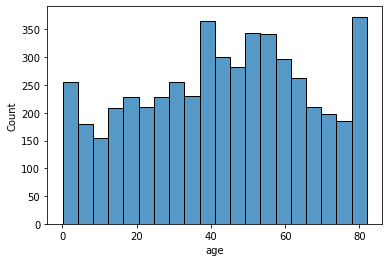

In [9]:
sns.histplot(data=df,x='age')

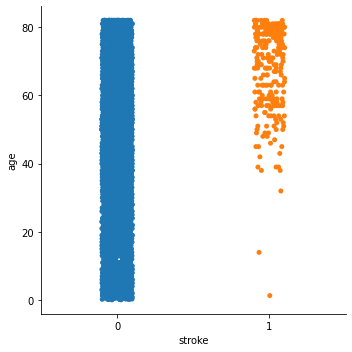

In [10]:
sns.catplot(data=df,x='stroke',y='age')

Let's look closer at the age of the people who had stroke. Below is a graph that shows how many patients have had a stroke for each age group.

In [11]:
df_age=df.drop(df[df['stroke']==0].index)
df_age=df_age[['age']]

<AxesSubplot:>

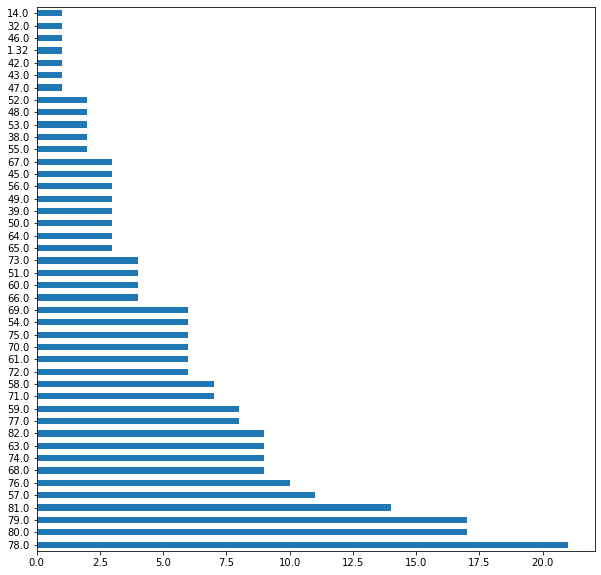

In [12]:
plt.rcParams["figure.figsize"] = (10,10)
df_age['age'].value_counts().plot(kind='barh')

In [13]:
#reset figure size to default
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

From this, we can see that those who've had a stroke tends to be older. Age could be a very important factor that will predict the occurence of stroke. Ages 78-81 have had the highest number of strokes.

**Gender**

In [14]:
print(df['gender'].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


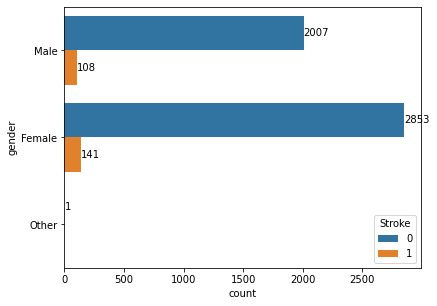

In [15]:
gen=sns.countplot(data=df,y='gender',hue='stroke')
for container in gen.containers:
  gen.bar_label(container)
plt.legend(loc='lower right',title='Stroke')

Notice that the female population (about 59%) is slightly higher than the male population which is approximately 41% of the total sample. 
Approximately 5.11% of the male patients had a stroke; 4.71% female patients and 0 other patients had a stroke.

**Hypertension**

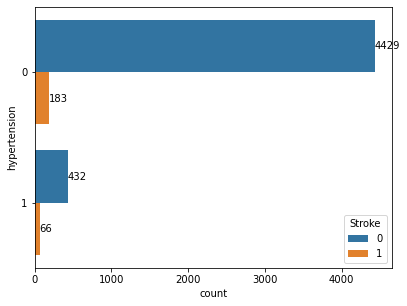

In [16]:
hp=sns.countplot(data=df,y='hypertension',hue='stroke')
for container in hp.containers:
  hp.bar_label(container)
plt.legend(loc='lower right',title='Stroke')

Those who has hypertension are more prone to experiencing a stroke. From the data, 13.25% of patients who have hypertension had a stroke while only 3.97% of those who does not have hypertension had a stroke.

**Heart disease**

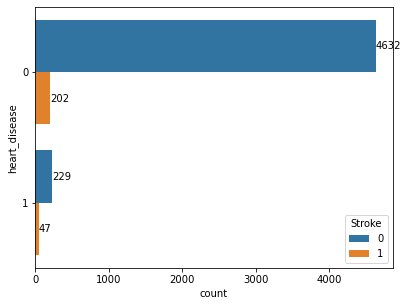

In [17]:
hd=sns.countplot(data=df,y='heart_disease',hue='stroke')
for container in hd.containers:
  hd.bar_label(container)
plt.legend(loc='lower right',title='Stroke')

17.03% of those who have any heart diseases had a stroke and 4.18% of those who doesn't have any heart diseases had a stroke. From this, we are more likely to assume that those who have any heart diseases have a higher chance of getting a stroke.

**Ever married**

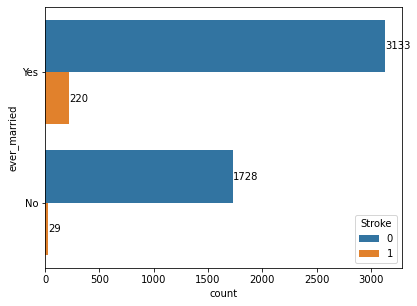

In [18]:
em=sns.countplot(data=df,y='ever_married',hue='stroke')
for container in em.containers:
  em.bar_label(container)
plt.legend(loc='lower right',title='Stroke')

Percentages of those patients who had a stroke:

Yes - 6.56%

No - 1.65%

Those who are married seems to have a higher percentage of having a stroke.

**Work type**

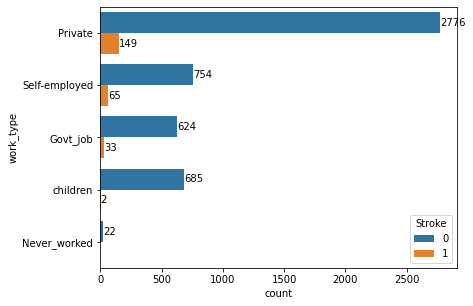

In [19]:
wt=sns.countplot(data=df,y='work_type',hue='stroke')
for container in wt.containers:
  wt.bar_label(container)
plt.legend(loc='lower right',title='Stroke')

Percentages of those patients who had a stroke:

Private - 5.09%

Self-employed - 7.94%

Govt job - 5.02%

Children - 0.29%

Never worked - 0%

Those who are self-employed seems to have the highest percentage.

**Residence Type**

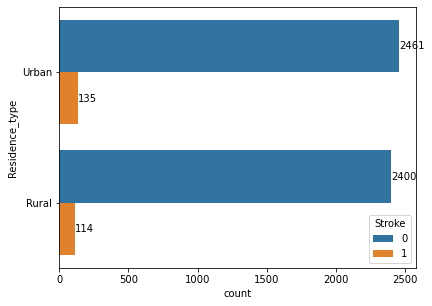

In [20]:
rt=sns.countplot(data=df,y='Residence_type',hue='stroke')
for container in rt.containers:
  rt.bar_label(container)
plt.legend(loc='lower right',title='Stroke')

Percentages of those patients who had a stroke:

Urban - 5.20%

Rural - 4.53%

The percentages between those who live in rural and urban areas and have had a stroke are almost the same, so the residence type might not be a very important factor that determines stroke prediction.

**Average glucose level**

<AxesSubplot:xlabel='avg_glucose_level', ylabel='Count'>

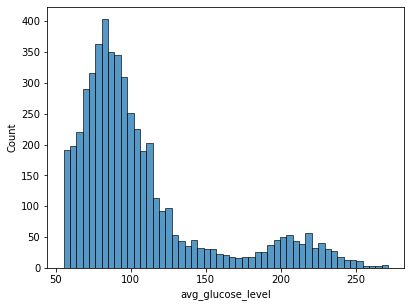

In [21]:
sns.histplot(data=df,x='avg_glucose_level')

The distribution of average glucose level is skewed to the right, indicating that the mean is lower than the median.

A blood sugar level less than 140 mg is considered normal. A reading more than 140 but less than 199 is considered prediabetic and 200 mg above is considered diabetic.

From the calculations below, we can see that those who are prediabetic and diabetic are more likely to experience a stroke.

In [22]:
u140=len(df.loc[(df.avg_glucose_level<140)&(df.stroke==1),['avg_glucose_level','stroke']])/len(df.loc[(df.avg_glucose_level<140),['avg_glucose_level','stroke']])*100
print("Patients under 140 mg who had a stroke: ",round(u140,2),"%")
o140=len(df.loc[(df.avg_glucose_level>140)&(df.stroke==1),['avg_glucose_level','stroke']])/len(df.loc[(df.avg_glucose_level>140),['avg_glucose_level','stroke']])*100
print("Patients under 140 mg who had a stroke: ",round(o140,2),"%")

Patients under 140 mg who had a stroke:  3.64 %
Patients under 140 mg who had a stroke:  11.33 %


**BMI**

<AxesSubplot:xlabel='bmi', ylabel='Count'>

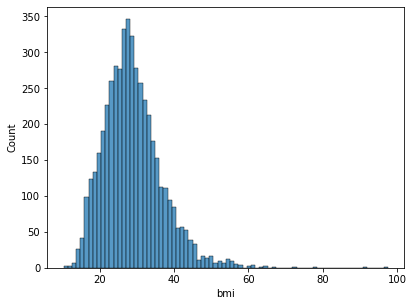

In [23]:
sns.histplot(data=df,x='bmi')

Looking at this histrogram, the distribution of bmi seems to be normal. However, we see that there are big outliers on the right hand side.

In [24]:
bbmi=len(df.loc[(df.bmi<18.5)&(df.stroke==1),['bmi','stroke']])/len(df.loc[(df.avg_glucose_level<140),['avg_glucose_level','stroke']])*100
print("Underweight patients who had a stroke: ",round(bbmi,2),"%")
hbmi=len(df.loc[(df.bmi>=18.5)&(df.bmi<=24.9)&(df.stroke==1),['bmi','stroke']])/len(df.loc[(df.bmi>=18.5)&(df.bmi<=24.9),['bmi','stroke']])*100
print("Healthy patients who had a stroke: ",round(hbmi,2),"%")
obmi=len(df.loc[(df.bmi>=25.0)&(df.bmi<=29.9)&(df.stroke==1),['bmi','stroke']])/len(df.loc[(df.bmi>=25.0)&(df.bmi<=29.9),['bmi','stroke']])*100
print("Overweight patients who had a stroke: ",round(obmi,2),"%")
obese=len(df.loc[(df.bmi>=30.0)&(df.stroke==1),['bmi','stroke']])/len(df.loc[(df.bmi>=30.0),['bmi','stroke']])*100
print("Obese patients who had a stroke: ",round(obese,2),"%")

Underweight patients who had a stroke:  0.02 %
Healthy patients who had a stroke:  2.82 %
Overweight patients who had a stroke:  5.32 %
Obese patients who had a stroke:  5.1 %


Overweight and obese patients who had stroke have higher percentages than underweight and healthy patients.

**Smoking Status**

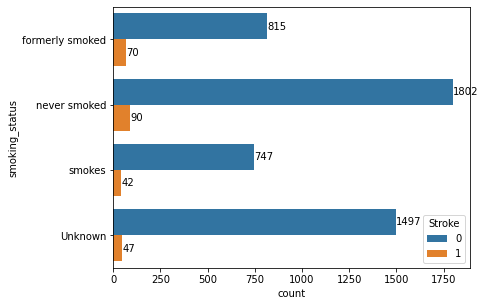

In [25]:
ss=sns.countplot(data=df,y='smoking_status',hue='stroke')
for container in ss.containers:
  ss.bar_label(container)
plt.legend(loc='lower right',title='Stroke')

Percentages of those patients who had stroke:

Formerly smoked - 7.91%

Never smoked - 4.76%

Smokes - 5.32%

Unknown - 3.04%

Those who formerly smoked and currently smokes are the top 2 among the patients who had stroke.

In [26]:
print(df['stroke'].value_counts())

0    4861
1     249
Name: stroke, dtype: int64


In [27]:
target=df[['stroke']]
print("0: ",round((target.value_counts()[0]/df.shape[0])*100,2), "%")
print("1: ",round((target.value_counts()[1]/df.shape[0])*100,2), "%")

0:  95.13 %
1:  4.87 %


Looking at our target values, we see that the data is imbalanced as ≈95% of the patients did not experience having a stroke. We will use different techniques on how to deal with imbalanced dataset later.

**Missing data**
---

<AxesSubplot:xlabel='bmi', ylabel='Count'>

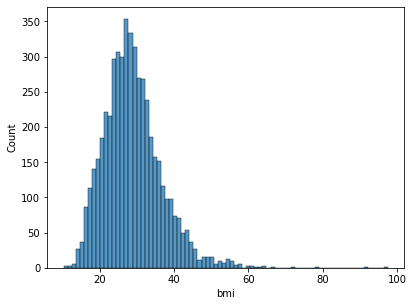

In [28]:
#Filling missing values in `bmi` column using linear interpolation
df['bmi'].interpolate(method='linear',direction='forward',inplace=True)
sns.histplot(data=df,x='bmi')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [30]:
#Separating features and target
features=df.drop(columns=['stroke'])
target=df[['stroke']]

**Numerical and Categorical Values**

In [31]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']
numerical = ['age','avg_glucose_level', 'bmi']
targetv=['stroke']

To avoid data leakage and bias, we'll encode the categorical variables after splitting the data into train and test sets.

Since we will be using tree-based methods such as Decision Tree, Random Forest and Gradient Boosting, the numerical features are not required to be scaled.

**Q1.**
---
 Train a `Decision Tree`, `Random Forest` and `Gradient Boosting` algorithm to set a
baseline performance. Use `ROC AUC `and `Average Precision` metrics for your evaluation.
Also, show the `precision` and `recall` for both classes. Don't balance the dataset.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [33]:
ohe=OneHotEncoder()
models = [DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier()]
names = ['Decision Tree','Random Forest','Gradient Boosting']

In [34]:
def initModel(models):
  for i in range(len(models)):
    transformer=ColumnTransformer(transformers=[('ohe',OneHotEncoder(),categorical)],remainder='passthrough')
    pipeline=Pipeline((('t',transformer),('m',models[i])))
    pipeline.fit(X_train,y_train)
    pred_train=pipeline.predict(X_train)
    pred_test=pipeline.predict(X_test)
    prob_train=pipeline.predict_proba(X_train)[:,1]
    prob_test=pipeline.predict_proba(X_test)[:,1]
    roc_train=roc_auc_score(y_train,prob_train)
    roc_test=roc_auc_score(y_test,prob_test)
    ap_train=average_precision_score(y_train,prob_train)
    ap_test=average_precision_score(y_test,prob_test)
    print("------------------------------------------------------")
    print(names[i],"ROC AUC (Train): ", round(roc_train,3))
    print(names[i],"ROC AUC (Test): ", round(roc_test,3))
    print(names[i],"Avg Precision (Train): ",round(ap_train,3))
    print(names[i],"Avg Precision (Test): ",round(ap_test,3))
    print('\nTrain\n',classification_report(y_train,pred_train))
    print('\nTest\n',classification_report(y_test,pred_test))
initModel(models)

------------------------------------------------------
Decision Tree ROC AUC (Train):  1.0
Decision Tree ROC AUC (Test):  0.509
Decision Tree Avg Precision (Train):  1.0
Decision Tree Avg Precision (Test):  0.052

Train
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3648
           1       1.00      1.00      1.00       184

    accuracy                           1.00      3832
   macro avg       1.00      1.00      1.00      3832
weighted avg       1.00      1.00      1.00      3832


Test
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      1213
           1       0.07      0.06      0.07        65

    accuracy                           0.91      1278
   macro avg       0.51      0.51      0.51      1278
weighted avg       0.91      0.91      0.91      1278

------------------------------------------------------
Random Forest ROC AUC (Train):  1.0
Random Forest ROC AUC (Test

It looks like the models are overfitting especially Random Forest and Decision Tree as they did really well on the training data and bad on the testing set. One reason could be because there is no pruning option used in the trees model.

Let's try `cross_validate` to further assess the models performance.

In [35]:
def initCV(models):
  for i in range(len(models)):
    transformer=ColumnTransformer(transformers=[('ohe',OneHotEncoder(),categorical)],remainder='passthrough')
    pipeline=Pipeline((('t',transformer),('m',models[i])))
    score=cross_validate(pipeline,X_train,y_train,cv=20,scoring=('roc_auc', 'average_precision'),return_train_score=True)
    print("\n",names[i],"\n",pd.DataFrame(score)[['train_roc_auc', 'train_average_precision']].mean())
    print("\n",names[i],"\n",pd.DataFrame(score)[['test_roc_auc', 'test_average_precision']].mean())
initCV(models)


 Decision Tree 
 train_roc_auc              1.0
train_average_precision    1.0
dtype: float64

 Decision Tree 
 test_roc_auc              0.566280
test_average_precision    0.075734
dtype: float64

 Random Forest 
 train_roc_auc              1.0
train_average_precision    1.0
dtype: float64

 Random Forest 
 test_roc_auc              0.786007
test_average_precision    0.184679
dtype: float64

 Gradient Boosting 
 train_roc_auc              0.937291
train_average_precision    0.632643
dtype: float64

 Gradient Boosting 
 test_roc_auc              0.835517
test_average_precision    0.226599
dtype: float64


From this, we can assume that the algorithm that will do best is the `Gradient Boosting` algorithm since it has the highest score. Next is `Random Forest` algorithm.

Imbalanced data set creates a bias towards one class. We'll balance the dataset using four methods: `Random Under Sampling`, `Random Over Sampling`, `Edited Nearest Neighbors` and `SMOTE`

**Q2.**
---
 Balance the dataset using any 4 methods we have discussed in the class and again train a `Decision Tree`, `Random Forest` and `Gradient Boosting` algorithm to compare the performance with models from Q1.

In [38]:
def q2SMOTE(models):
  print("SMOTE")
  for i in range(len(models)):
    transformer=ColumnTransformer(transformers=[('ohe',OneHotEncoder(),categorical)],remainder='passthrough')
    pipeline=imb_pipeline(steps=[('ohe',transformer),('i',SMOTE()),('m',models[i])])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    roc=roc_auc_score(y_test,y_prob)
    ap=average_precision_score(y_test,y_prob)
    print("-------------------------------------------------------")
    print(names[i], "ROC AUC: ",round(roc,3))
    print(names[i], "Avg Precision: ",round(ap,3))
    print(classification_report(y_test, y_pred))

q2SMOTE(models)

SMOTE
-------------------------------------------------------
Decision Tree ROC AUC:  0.575
Decision Tree Avg Precision:  0.076
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1213
           1       0.18      0.20      0.19        65

    accuracy                           0.91      1278
   macro avg       0.57      0.58      0.57      1278
weighted avg       0.92      0.91      0.91      1278

-------------------------------------------------------
Random Forest ROC AUC:  0.699
Random Forest Avg Precision:  0.103
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1213
           1       0.12      0.02      0.03        65

    accuracy                           0.94      1278
   macro avg       0.54      0.50      0.50      1278
weighted avg       0.91      0.94      0.92      1278

-------------------------------------------------------
Gradient Boosting ROC AUC:  0.776
Gradie

In [39]:
def q2ROS(models):
  print("Random Over Sampling")
  for i in range(len(models)):
    transformer=ColumnTransformer(transformers=[('ohe',OneHotEncoder(),categorical)],remainder='passthrough')
    pipeline=imb_pipeline(steps=[('ohe',transformer),('i',RandomOverSampler()),('m',models[i])])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    roc=roc_auc_score(y_test,y_prob)
    ap=average_precision_score(y_test,y_prob)
    print("-------------------------------------------------------")
    print(names[i], "ROC AUC: ",round(roc,3))
    print(names[i], "Avg Precision: ",round(ap,3))
    print(classification_report(y_test, y_pred))
q2ROS(models)

Random Over Sampling
-------------------------------------------------------
Decision Tree ROC AUC:  0.561
Decision Tree Avg Precision:  0.074
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1213
           1       0.20      0.15      0.18        65

    accuracy                           0.93      1278
   macro avg       0.58      0.56      0.57      1278
weighted avg       0.92      0.93      0.92      1278

-------------------------------------------------------
Random Forest ROC AUC:  0.745
Random Forest Avg Precision:  0.115
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1213
           1       0.19      0.05      0.07        65

    accuracy                           0.94      1278
   macro avg       0.57      0.52      0.52      1278
weighted avg       0.91      0.94      0.92      1278

-------------------------------------------------------
Gradient Boosting ROC AUC

In [40]:
def q2RUS(models):
  print("Random Under Sampling")
  fi=list()
  for i in range(len(models)):
    transformer=ColumnTransformer(transformers=[('ohe',OneHotEncoder(),categorical)],remainder='passthrough')
    pipeline=imb_pipeline(steps=[('ohe',transformer),('i',RandomUnderSampler()),('m',models[i])])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    roc=roc_auc_score(y_test,y_prob)
    ap=average_precision_score(y_test,y_prob)
    print("-------------------------------------------------------")
    print(names[i], "ROC AUC: ",round(roc,3))
    print(names[i], "Avg Precision: ",round(ap,3))
    print(classification_report(y_test, y_pred))
    coefs=pipeline.named_steps['m'].feature_importances_.flatten()
    fn=pipeline.named_steps['ohe'].get_feature_names()
    fi.append(coefs)
  return fi,fn
feat,fname=q2RUS(models)

Random Under Sampling
-------------------------------------------------------
Decision Tree ROC AUC:  0.655
Decision Tree Avg Precision:  0.081
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      1213
           1       0.10      0.58      0.17        65

    accuracy                           0.72      1278
   macro avg       0.54      0.66      0.50      1278
weighted avg       0.93      0.72      0.80      1278

-------------------------------------------------------
Random Forest ROC AUC:  0.781
Random Forest Avg Precision:  0.145
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1213
           1       0.12      0.74      0.20        65

    accuracy                           0.71      1278
   macro avg       0.55      0.72      0.51      1278
weighted avg       0.94      0.71      0.79      1278

-------------------------------------------------------
Gradient Boosting ROC AU

In [41]:
def q2ENN(models):
  print("Edited Nearest Neighbors")
  fi=list()
  for i in range(len(models)):
    transformer=ColumnTransformer(transformers=[('ohe',OneHotEncoder(),categorical)],remainder='passthrough')
    pipeline=imb_pipeline(steps=[('ohe',transformer),('i',EditedNearestNeighbours()),('m',models[i])])
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    roc=roc_auc_score(y_test,y_prob)
    ap=average_precision_score(y_test,y_prob)
    print("-------------------------------------------------------")
    print(names[i], "ROC AUC: ",round(roc,3))
    print(names[i], "Avg Precision: ",round(ap,3))
    print(classification_report(y_test, y_pred))
    coefs=pipeline.named_steps['m'].feature_importances_.flatten()
    fn=pipeline.named_steps['ohe'].get_feature_names()
    fi.append(coefs)
  return fi,fn
featENN,fnameENN=q2ENN(models)

Edited Nearest Neighbors
-------------------------------------------------------
Decision Tree ROC AUC:  0.56
Decision Tree Avg Precision:  0.066
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1213
           1       0.13      0.18      0.15        65

    accuracy                           0.90      1278
   macro avg       0.54      0.56      0.55      1278
weighted avg       0.91      0.90      0.90      1278

-------------------------------------------------------
Random Forest ROC AUC:  0.76
Random Forest Avg Precision:  0.154
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1213
           1       0.30      0.05      0.08        65

    accuracy                           0.95      1278
   macro avg       0.63      0.52      0.53      1278
weighted avg       0.92      0.95      0.93      1278

-------------------------------------------------------
Gradient Boosting ROC A

**Q3.** 
---
Find the important features using Random Forest and Gradient Boosting algorithms.

Text(0.5, 0, 'Feature Names')

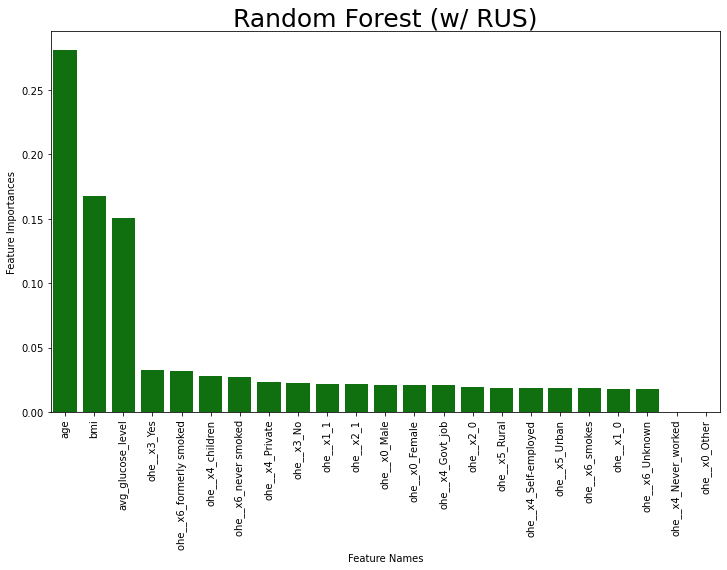

In [42]:
zipped=zip(fname,feat[1])
dfeat=pd.DataFrame(zipped,columns=['feature','value'])
dfeat['abs_value'] = dfeat['value'].apply(lambda x: abs(x))
dfeat['colors'] = dfeat['value'].apply(lambda x: 'green' if x > 0 else 'red')
dfeat = dfeat.sort_values('abs_value', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x='feature',y='value',data=dfeat,palette=dfeat["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Random Forest (w/ RUS)", fontsize=25)
ax.set_ylabel("Feature Importances")
ax.set_xlabel("Feature Names")

Top 3 features from this model (Random Forest with Random Under Sampler):

*   Age
*   Bmi
*   Glucose level

Text(0.5, 0, 'Feature Names')

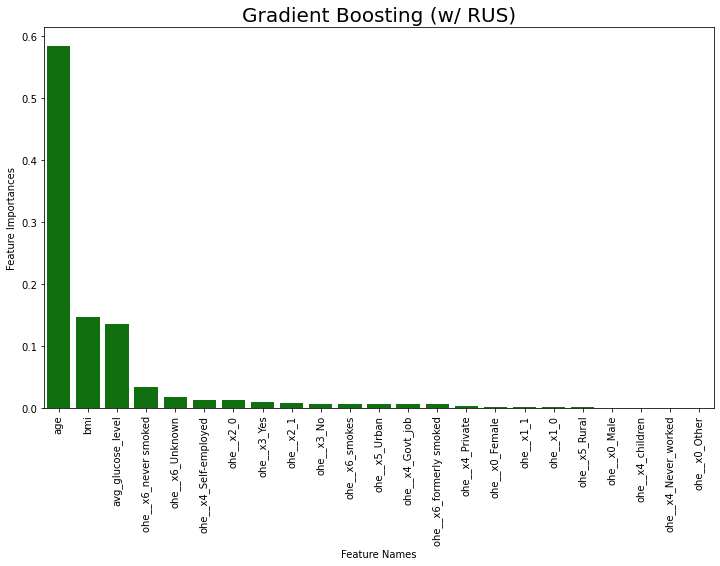

In [43]:
zipped=zip(fname,feat[2])
dfeat=pd.DataFrame(zipped,columns=['feature','value'])
dfeat['abs_value'] = dfeat['value'].apply(lambda x: abs(x))
dfeat['colors'] = dfeat['value'].apply(lambda x: 'green' if x > 0 else 'red')
dfeat = dfeat.sort_values('abs_value', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x='feature',y='value',data=dfeat,palette=dfeat["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Gradient Boosting (w/ RUS)", fontsize=20)
ax.set_ylabel("Feature Importances")
ax.set_xlabel("Feature Names")

Top 5 features from this model (Gradient Boosting with Random Under Sampler):

*   Age
*   Bmi
*   Glucose level

Text(0.5, 0, 'Feature Names')

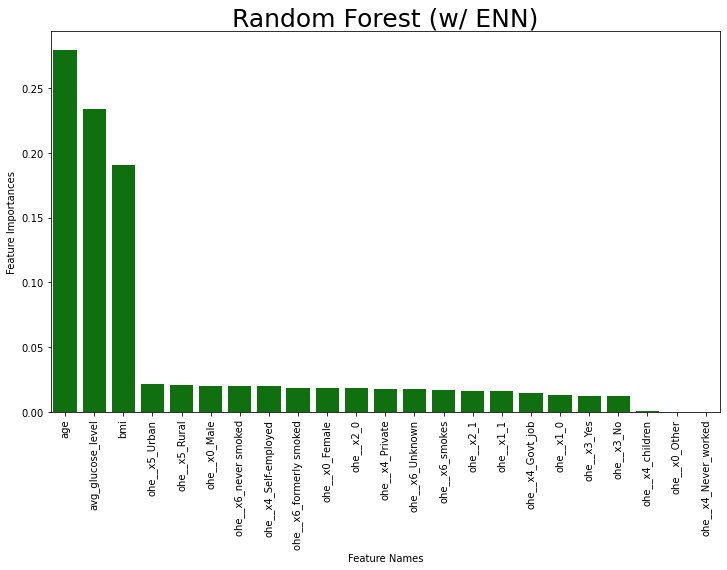

In [44]:
zipped=zip(fnameENN,featENN[1])
dfeat=pd.DataFrame(zipped,columns=['feature','value'])
dfeat['abs_value'] = dfeat['value'].apply(lambda x: abs(x))
dfeat['colors'] = dfeat['value'].apply(lambda x: 'green' if x > 0 else 'red')
dfeat = dfeat.sort_values('abs_value', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x='feature',y='value',data=dfeat,palette=dfeat["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Random Forest (w/ ENN)", fontsize=25)
ax.set_ylabel("Feature Importances")
ax.set_xlabel("Feature Names")

Top 3 features from this model (Random Forest with Edited Nearest Neighbors):

*   Age
*   Glucose level
*   Bmi

Text(0.5, 0, 'Feature Names')

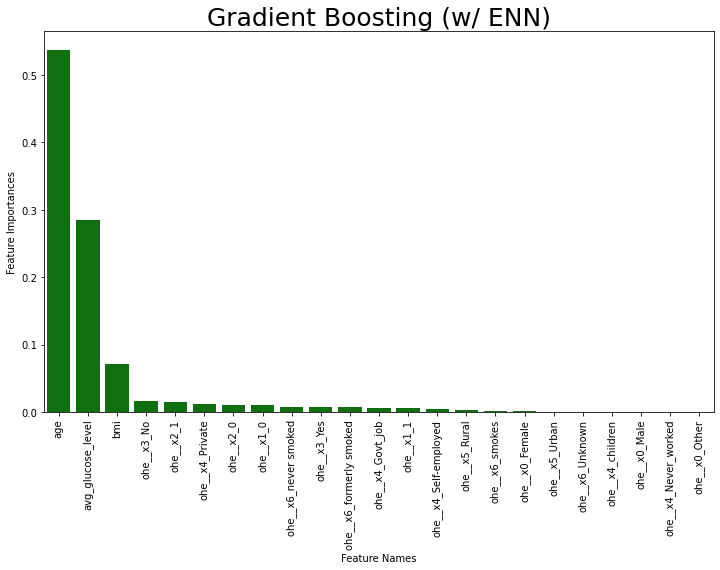

In [45]:
zipped=zip(fnameENN,featENN[2])
dfeat=pd.DataFrame(zipped,columns=['feature','value'])
dfeat['abs_value'] = dfeat['value'].apply(lambda x: abs(x))
dfeat['colors'] = dfeat['value'].apply(lambda x: 'green' if x > 0 else 'red')
dfeat = dfeat.sort_values('abs_value', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x='feature',y='value',data=dfeat,palette=dfeat["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Gradient Boosting (w/ ENN)", fontsize=25)
ax.set_ylabel("Feature Importances")
ax.set_xlabel("Feature Names")

Top 3 features from this model (Gradient Boosting with Edited Nearest Neighbors):

*   Age
*   Glucose level
*   Bmi

The four models above have the same top three features and those are Age, Glucose level and Bmi and from our exploratory analysis earlier, these factors have the highest correlations in telling if patients are going to experience a stroke.

---
**Brief summary on how different balancing techniques affected the performance of the models**


Models |Imbalanced | SMOTE | ROS | RUS | ENN
-------------------|-------------------|------------------ |------------------ |------------------ |------------------
**Decision Tree**| *ROC*: 0.566, *AP*: 0.0757 |0.575, 0.076 | 0.561, 0.074 | 0.655, 0.081 | 0.56, 0.066
**Random Forest**| *ROC*: 0.786, *AP*: 0.184 | 0.699, 0.103 | 0.745, 0.115 | 0.781, 0.145 | 0.75, 0.154 
**Gradient Boosting**| *ROC*: 0.835, *AP*: 0.226 | 0.776, 0.142 | 0.794, 0.152 | 0.791, 0.14 | 0.801, 0.146 


---


-----------------------
References:

https://stackoverflow.com/questions/55104819/display-count-on-top-of-seaborn-barplot

https://mode.com/python-tutorial/counting-and-plotting-in-python/

https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

https://towardsdatascience.com/how-to-deal-with-missing-data-in-python-1f74a9112d93

https://medium.com/@lily_su/confusion-matrix-roc-auc-and-imbalanced-classes-in-logistic-regression-5c7ead3deefc

https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
